In [121]:
import re
from collections import Counter
from functools import partial

import grapheme
import pandas as pd

import mpl_axes_aligner.align
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(9872)
from scipy.stats import kendalltau
from tqdm import tqdm

from bokeh.models import HoverTool, ColumnDataSource
from bokeh.plotting import figure, show, output_file, save
from bokeh.io import output_file, show, save, output_notebook
from bokeh.plotting import figure
from bokeh.models import Axis

import seaborn as sb

import unicodedata

from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

plt.rcParams["font.family"] = "Junicode"

## Preprocessing

In [122]:
transcriptions = pd.read_excel('../data/silentvoices_manuscript_data.xlsx')
transcriptions['id'] = transcriptions['codex_sig'] + '-' + transcriptions['production unit'] + '-' + transcriptions['scribe']
transcriptions.head(5)

,Unnamed: 0,codex_sig,transkribuspage,image_filename,image_width,image_height,region_type,coordinates,text,reading_order,...,language,scribe,production unit,local Herne product,date,translator,transcription,HTR-model used,CER?,id
0,0,"Brussel, KBR, 1805-1808",7,0007_KBR_1805-08_1r.tiff,5186,7123,header,"1405,478 3598,478 3598,721 1405,721",Een voorredene op sinte gregoriꝰ dyalogus,0,...,middledutch,a,I,yes,1400,bibletranslator,GT,NaN,NaN,"Brussel, KBR, 1805-1808-I-a"
1,1,"Brussel, KBR, 1805-1808",7,0007_KBR_1805-08_1r.tiff,5186,7123,paragraph,"1359,751 3792,751 3792,2645 1359,2645",DE zeere wise e saleghe gregoris paeus\nvan d...,1,...,middledutch,a,I,yes,1400,bibletranslator,GT,NaN,NaN,"Brussel, KBR, 1805-1808-I-a"
2,2,"Brussel, KBR, 1805-1808",8,0008_KBR_1805-08_1v.tiff,5186,7123,paragraph,"1736,658 3985,658 3985,1643 1736,1643",wiste dat si hare te xpūs gheloeue ghege-\nuen...,0,...,middledutch,a,I,yes,1400,bibletranslator,GT,NaN,NaN,"Brussel, KBR, 1805-1808-I-a"
3,3,"Brussel, KBR, 1805-1808",8,0008_KBR_1805-08_1v.tiff,5186,7123,marginalia,"2414,1705 4016,1705 4016,1851 2414,1851",⸫ Nēmeer en vant ics jnt latijn .,1,...,middledutch,a,I,yes,1400,bibletranslator,GT,NaN,NaN,"Brussel, KBR, 1805-1808-I-a"
4,4,"Brussel, KBR, 1805-1808",9,0009_KBR_1805-08_2r.tiff,5186,7123,paragraph,"859,5840 847,5678 835,5462 781,4838 751,4480 7...",Hier beghint een voʼredene\nop .Sʼ. gᵉgorius d...,0,...,middledutch,α,I,yes,1395,bibletranslator,GT,NaN,NaN,"Brussel, KBR, 1805-1808-I-α"


In [123]:
units = []
plain_char = re.compile("[A-Za-z]+")

for pu_id, pu in transcriptions.groupby('id'):
    pu = pu.sort_values('transkribuspage')
    pu = pu[~pu['text'].isna()]
    if not len(pu):
        continue
    text = ' '.join(t for t in pu['text'])
    text = ' '.join(text.strip().split())
    
    date = pu.sample(1)['date'].values[0]
    scribe = pu.sample(1)['scribe'].values[0]
    sig = pu.sample(1)['codex_sig'].values[0]
    content = '<UNK>'
    try:
        content = ' - '.join(Counter(pu['content']))
    except:
        pass
    
    try:
        if plain_char.fullmatch(scribe):
            scribe = sig + '-' + scribe
    except TypeError:
        scribe = '<UNK>'
        
    translator = pu.sample(1)['translator'].values[0]
    units.append((pu_id, date, text, scribe, sig, pu_id, translator, content))

H = pd.DataFrame(units, columns=['pu', 'date', 'text', 'scribe', 'signature', 'id', 'translator', 'content'])
H.sample(10)

,pu,date,text,scribe,signature,id,translator,content
74,"Sint-Petersburg, BAN, O 256-I-B",1325-1350,,"Sint-Petersburg, BAN, O 256-B","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-I-B",NaN,perikopen
50,"Gent, UB, 941-I-II-scribe2",1375-1400,te comē plach ¶ Een Joncfrouwe van colne e hi...,scribe2,"Gent, UB, 941","Gent, UB, 941-I-II-scribe2",NaN,HadLijst-HadBrief
5,"Brussel, KBR, 1805-1808-III-β",1395,Jn de wihinghē vā dʼ kerkē beda sermoem Bhhed ...,β,"Brussel, KBR, 1805-1808","Brussel, KBR, 1805-1808-III-β",none,preekBeda - preekBeda-preekPsBeda - preekPsBed...
33,"Brussel, KBR, 2979-II-α",1350,J theꝰ ghel seide dē wiuē ātwʼdende En wilt v ...,α,"Brussel, KBR, 2979","Brussel, KBR, 2979-II-α",NaN,evangMat
42,"Brusssel, KBR, 3093-95-II-unknown",1450-1500,Dit boec es des cloesters va rode dale in soni...,"Brusssel, KBR, 3093-95-unknown","Brusssel, KBR, 3093-95","Brusssel, KBR, 3093-95-II-unknown",NaN,note - TOC
109,"Wenen, ONB, 65-I-γ",1375-1400,‡ d blie die pase on heeren ihoes so voerga en...,γ,"Wenen, ONB, 65","Wenen, ONB, 65-I-γ",NaN,TOC
94,"Wenen, ONB, 13708-III-none",1402,.46.,"Wenen, ONB, 13708-none","Wenen, ONB, 13708","Wenen, ONB, 13708-III-none",NaN,none
25,"Brussel, KBR, 2879-80-III-scribe2-scribe3",1325-1350,mi dat ic di ꝟwinne Jn dine onuʼ- wonnene crac...,scribe2-scribe3,"Brussel, KBR, 2879-80","Brussel, KBR, 2879-80-III-scribe2-scribe3",none,HadLied
20,"Brussel, KBR, 2879-80-I-scribe1",1325-1350,E wat hi u gh eloeft he uet GOd die de clare ...,scribe1,"Brussel, KBR, 2879-80","Brussel, KBR, 2879-80-I-scribe1",none,HadBrief
62,"Parijs, Bibliotheque Mazarine, 920-VI-L",1375-1400,⸫ Spiegel des sondʼs ⸫ O alre liefste broeder ...,"Parijs, Bibliotheque Mazarine, 920-L","Parijs, Bibliotheque Mazarine, 920","Parijs, Bibliotheque Mazarine, 920-VI-L",NaN,spiegelsondaren


In [124]:
num_dates = []

for d in H['date']:
    if d in ('unknown', 'no'):
        d = None
    else:
        try:
            d = int(d)
        except ValueError:
            if '-' in d:
                d1, d2 = d.split('-')
                d1, d2 = int(d1), int(d2)
                d = d1 + ((d2 - d1) / 2)
            if d == 'none':
                d = None
    num_dates.append(d)
    
H['num_date'] = num_dates
H['length'] = H['text'].str.len()
H = H.sort_values('num_date')
H.head()

,pu,date,text,scribe,signature,id,translator,content,num_date,length
25,"Brussel, KBR, 2879-80-III-scribe2-scribe3",1325-1350,mi dat ic di ꝟwinne Jn dine onuʼ- wonnene crac...,scribe2-scribe3,"Brussel, KBR, 2879-80","Brussel, KBR, 2879-80-III-scribe2-scribe3",none,HadLied,1337.5,2264
26,"Brussel, KBR, 2879-80-III-scribe3",1325-1350,Jc ben dat ic was wilen eer . Nu valle in mine...,scribe3,"Brussel, KBR, 2879-80","Brussel, KBR, 2879-80-III-scribe3",none,HadLied - HadLied-HadMeng - HadMeng,1337.5,118389
74,"Sint-Petersburg, BAN, O 256-I-B",1325-1350,,"Sint-Petersburg, BAN, O 256-B","Sint-Petersburg, BAN, O 256","Sint-Petersburg, BAN, O 256-I-B",NaN,perikopen,1337.5,0
24,"Brussel, KBR, 2879-80-III-scribe2",1325-1350,AY al es nu die winter cout Cort de daghe e d...,scribe2,"Brussel, KBR, 2879-80","Brussel, KBR, 2879-80-III-scribe2",none,HadLied,1337.5,38565
23,"Brussel, KBR, 2879-80-II-scribe2",1325-1350,HEt was in ene sōdage tʼ octauē vā pētecostē d...,scribe2,"Brussel, KBR, 2879-80","Brussel, KBR, 2879-80-II-scribe2",none,HadVis - HadVis-HadLijst - HadLijst,1337.5,90526


In [125]:
print(len(H))
H = H[H['length'] > 2500]
print(len(H))

113
63


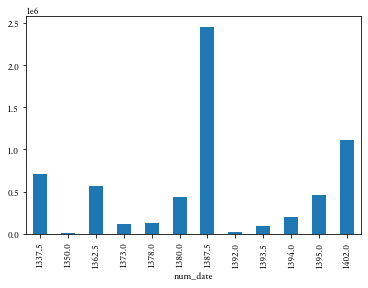

In [126]:
H.groupby('num_date')['length'].sum().plot.bar();

## Graphemes?

Elements allowed in ground truth?

In [127]:
allowed_chars = ''.join([t for t in transcriptions[transcriptions['transcription'] == 'GT']['text'] if isinstance(t, str)])
allowed_chars = Counter(allowed_chars)
allowed_chars

Counter({'E': 5679,
         'e': 216728,
         'n': 64373,
         ' ': 268208,
         'v': 17443,
         'o': 46691,
         'r': 36459,
         'd': 72093,
         'p': 8135,
         's': 64138,
         'i': 68690,
         't': 71726,
         'g': 32034,
         'ꝰ': 827,
         'y': 2052,
         'a': 51851,
         'l': 44463,
         'u': 20315,
         'D': 7105,
         'z': 1361,
         'w': 19666,
         '\ue5dc': 12826,
         'h': 47896,
         '\n': 43868,
         'm': 27302,
         'b': 14441,
         'c': 31747,
         'k': 9072,
         'ē': 44545,
         'ʼ': 24246,
         '.': 16694,
         'W': 2132,
         '-': 6835,
         'ū': 303,
         'ā': 8733,
         '\uf161': 50,
         'H': 1790,
         'j': 4791,
         'f': 5939,
         'x': 1842,
         '⸫': 212,
         'N': 1139,
         'S': 2019,
         'ᵉ': 1229,
         'O': 888,
         'ꝑ': 321,
         'ᵃ': 1511,
         'ꝫ': 7189,
         '

In [128]:
plain_char = re.compile("[A-Za-z]+")

letters, glyphs, punctuation = [], [], []

for g, c in allowed_chars.items():
    # ignore:
    if g.isnumeric():
        continue
    if g.isspace():
        continue
    if plain_char.fullmatch(g):
        letters.append((g, c))
    elif g.isalpha():
        glyphs.append((g, c))
    else:
        punctuation.append((g, c))

letters = Counter(dict(letters))
glyphs = Counter(dict(glyphs))
punctuation = Counter(dict(punctuation))

print(letters.most_common(5))
print(glyphs.most_common(5))
print(punctuation.most_common(5))

[('e', 216728), ('d', 72093), ('t', 71726), ('i', 68690), ('n', 64373)]
[('ē', 44545), ('ʼ', 24246), ('ī', 9056), ('ā', 8733), ('ꝫ', 7189)]
[('.', 16694), ('\ue5dc', 12826), (':', 9738), ('-', 6835), ('\ue554', 2259)]


Only keep characters that are attested in the ground truth transcriptions:

In [129]:
def clean(text):
    text = ' '.join(text.split())
    return ''.join([c for c in text if c in allowed_chars])

H['text'] = H['text'].apply(clean)
H

,pu,date,text,scribe,signature,id,translator,content,num_date,length
26,"Brussel, KBR, 2879-80-III-scribe3",1325-1350,Jc ben dat ic was wilen eer . Nu valle in mine...,scribe3,"Brussel, KBR, 2879-80","Brussel, KBR, 2879-80-III-scribe3",none,HadLied - HadLied-HadMeng - HadMeng,1337.5,118389
24,"Brussel, KBR, 2879-80-III-scribe2",1325-1350,AY al es nu die winter cout Cort de daghe e d...,scribe2,"Brussel, KBR, 2879-80","Brussel, KBR, 2879-80-III-scribe2",none,HadLied,1337.5,38565
23,"Brussel, KBR, 2879-80-II-scribe2",1325-1350,HEt was in ene sōdage tʼ octauē vā pētecostē d...,scribe2,"Brussel, KBR, 2879-80","Brussel, KBR, 2879-80-II-scribe2",none,HadVis - HadVis-HadLijst - HadLijst,1337.5,90526
22,"Brussel, KBR, 2879-80-I-scribe2",1325-1350,Niet opten loen Si beuelēt alder minnen dies e...,scribe2,"Brussel, KBR, 2879-80","Brussel, KBR, 2879-80-I-scribe2",none,HadBrief,1337.5,112630
20,"Brussel, KBR, 2879-80-I-scribe1",1325-1350,E wat hi u gh eloeft he uet GOd die de clare ...,scribe1,"Brussel, KBR, 2879-80","Brussel, KBR, 2879-80-I-scribe1",none,HadBrief,1337.5,39574
...,...,...,...,...,...,...,...,...,...,...
96,"Wenen, ONB, 13708-IV-α",1402,Dander ptie Dē vorredene vā dē andʼen boeke WJ...,α,"Wenen, ONB, 13708","Wenen, ONB, 13708-IV-α",NaN,sph2-2,1402.0,109567
95,"Wenen, ONB, 13708-III-α",1402,¶ Hoe petʼ ordineʼde clemēte Vaeus te sine na ...,α,"Wenen, ONB, 13708","Wenen, ONB, 13708-III-α",NaN,sph2-1,1402.0,96141
93,"Wenen, ONB, 13708-II-α",1402,a Doemē screef .m.ccc. e .xcvi. op de derde n...,α,"Wenen, ONB, 13708","Wenen, ONB, 13708-II-α",NaN,kroniekbrabant - sph4 - lekenspiegel - corpusi...,1402.0,147236
98,"Wenen, ONB, 13708-IX-α",1402,Dander ꝑtie De seuēde boec De vor redene vā dē...,α,"Wenen, ONB, 13708","Wenen, ONB, 13708-IX-α",NaN,sph2-7,1402.0,151095


Remove punctuation:

In [130]:
BREAK = re.compile(r'\-\s+')
NUMBER = re.compile(r'[0-9]+')

def rm_punct(text):
    text = re.sub(BREAK, '', text)
    text = re.sub(NUMBER, '', text)
    return ''.join([c for c in text if c not in punctuation])

H['text'] = H['text'].apply(rm_punct)
H

,pu,date,text,scribe,signature,id,translator,content,num_date,length
26,"Brussel, KBR, 2879-80-III-scribe3",1325-1350,Jc ben dat ic was wilen eer Nu valle in minen...,scribe3,"Brussel, KBR, 2879-80","Brussel, KBR, 2879-80-III-scribe3",none,HadLied - HadLied-HadMeng - HadMeng,1337.5,118389
24,"Brussel, KBR, 2879-80-III-scribe2",1325-1350,AY al es nu die winter cout Cort de daghe e de...,scribe2,"Brussel, KBR, 2879-80","Brussel, KBR, 2879-80-III-scribe2",none,HadLied,1337.5,38565
23,"Brussel, KBR, 2879-80-II-scribe2",1325-1350,HEt was in ene sōdage tʼ octauē vā pētecostē d...,scribe2,"Brussel, KBR, 2879-80","Brussel, KBR, 2879-80-II-scribe2",none,HadVis - HadVis-HadLijst - HadLijst,1337.5,90526
22,"Brussel, KBR, 2879-80-I-scribe2",1325-1350,Niet opten loen Si beuelēt alder minnen dies e...,scribe2,"Brussel, KBR, 2879-80","Brussel, KBR, 2879-80-I-scribe2",none,HadBrief,1337.5,112630
20,"Brussel, KBR, 2879-80-I-scribe1",1325-1350,E wat hi u gh eloeft he uet GOd die de clare M...,scribe1,"Brussel, KBR, 2879-80","Brussel, KBR, 2879-80-I-scribe1",none,HadBrief,1337.5,39574
...,...,...,...,...,...,...,...,...,...,...
96,"Wenen, ONB, 13708-IV-α",1402,Dander ptie Dē vorredene vā dē andʼen boeke WJ...,α,"Wenen, ONB, 13708","Wenen, ONB, 13708-IV-α",NaN,sph2-2,1402.0,109567
95,"Wenen, ONB, 13708-III-α",1402,Hoe petʼ ordineʼde clemēte Vaeus te sine na h...,α,"Wenen, ONB, 13708","Wenen, ONB, 13708-III-α",NaN,sph2-1,1402.0,96141
93,"Wenen, ONB, 13708-II-α",1402,a Doemē screef mccc e xcvi op de derde none vā...,α,"Wenen, ONB, 13708","Wenen, ONB, 13708-II-α",NaN,kroniekbrabant - sph4 - lekenspiegel - corpusi...,1402.0,147236
98,"Wenen, ONB, 13708-IX-α",1402,Dander ꝑtie De seuēde boec De vor redene vā dē...,α,"Wenen, ONB, 13708","Wenen, ONB, 13708-IX-α",NaN,sph2-7,1402.0,151095


## Visualize

In [131]:
segment_size = 5000
segments = []
for _, row in H.iterrows():
    si, ei = 0, segment_size
    text = row['text']
    while ei < len(text):
        segments.append((text[si:ei], row['num_date'], row['scribe'], row['signature'], row['id'], row['translator'], row['content']))
        si += segment_size
        ei += segment_size

segments = pd.DataFrame(segments, columns=['text', 'date', 'scribe', 'signature', 'id', 'translator', 'content'])
segments.sample(5)

,text,date,scribe,signature,id,translator,content
300,legē leuene e wel e scone gheordeneert e beset...,1380.0,"Brussel, KBR, 2877-78-A","Brussel, KBR, 2877-78","Brussel, KBR, 2877-78-I-A",NaN,HadBrief - HadVis - HadVis-HadLijst - HadLijst...
712,ewelekʼ gloriē Si es ī vredē e se ker si ē o...,1387.5,α,"Brusssel, KBR, 3093-95","Brusssel, KBR, 3093-95-I-α",NaN,waerdeAug
718,be kīne de werdege beelde in di seluē dʼ heil...,1387.5,α,"Brusssel, KBR, 3093-95","Brusssel, KBR, 3093-95-I-α",NaN,waerdeAug
727,dʼ waʼhᵗ maʼ geloe dan ē gherē awt axed saon...,1387.5,α,"Brussel, KBR, 2849-51","Brussel, KBR, 2849-51-III-α",NaN,briefPaulusadRom
1155,ebbene dinē gheʼe Wāt het gaet bouē mēschē sin...,1402.0,α,"Wenen, ONB, 13708","Wenen, ONB, 13708-IX-α",NaN,sph2-7


Abbreviation density?

In [132]:
def abbr_density(text):
    cnts = Counter(unicodedata.normalize('NFD', text))
    alph = np.sum([cnts[c] for c in set(letters)])
    glph = np.sum([cnts[c] for c in set(glyphs)])
    return glph / alph
    

densities = [abbr_density(t) for t in segments['text']]
segments['abbr'] = densities

/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 949 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 945 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 949 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 945 missing from current font.
  font.set_text(s, 0, flags=flags)


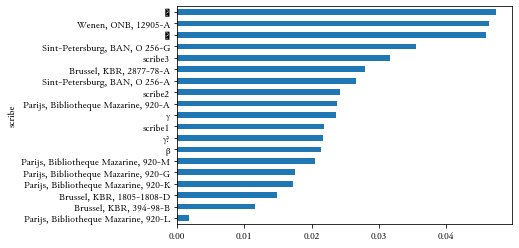

In [149]:
segments.groupby('scribe')['abbr'].mean().sort_values(ascending=False)[::-1].plot.barh();

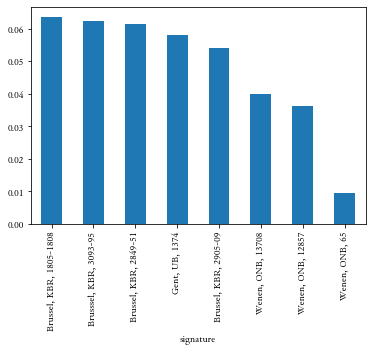

In [150]:
segments[segments['scribe'] == 'α'].groupby('signature')['abbr'].mean().sort_values(ascending=False).plot.bar();

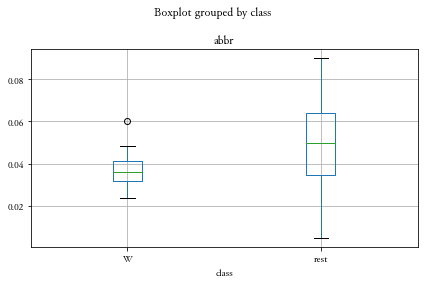

In [151]:
classes = ['W' if sig == 'Wenen, ONB, 12857' else 'rest' for sig in segments['signature']]
segments['class'] = classes
segments[segments['scribe'] == 'α'].boxplot('abbr', 'class')
plt.tight_layout();

## Derde Martijn

In [152]:
with open('../data/M3/Ghent1374_DerdeMartijn.txt') as f:
    G = f.read()
with open('../data/M3/ONB13708_DerdeMartijn.txt') as f:
    W = f.read()

G = clean(rm_punct(G))
W = clean(rm_punct(W))

print(G[:100])
print(W[:100])

print('Ghent:', abbr_density(G).round(4))
print('Vienna:', abbr_density(W).round(4))

En hier volgt de dʼde boec IC māne mettē wiuē Die dit gedichte lesē en scᶦuē Op dē hoechstē ban Dꝫ s
Hier willic settē dē dʼdē boec vā wapen mʼtē die iacob vā marlāt maecte ō dꝫ hi vā dē ge loeue spᵉct
Ghent: 0.0482
Vienna: 0.0266


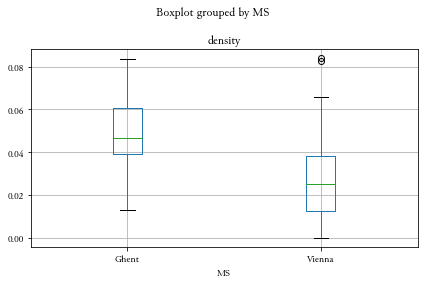

In [153]:
def segment(text, segment_size=100):
    si, ei = 0, segment_size
    while ei < len(text):
        yield text[si:ei]
        si += segment_size
        ei += segment_size
        
segment_size = 200
Gs = segment(G, segment_size)
Ws = segment(W, segment_size)

densities = []
for g in Gs:
    densities.append(('Ghent', abbr_density(g)))
for w in Ws:
    densities.append(('Vienna', abbr_density(w)))
densities = pd.DataFrame(densities, columns=['MS', 'density'])
densities.boxplot('density', 'MS')
plt.tight_layout();

## Vectorization

In [154]:
#segments = segments[segments['scribe'].isin(['α', 'β'])]
#segments = segments[segments['scribe'] == 'α']

In [155]:
import unicodedata

def ngrams(text, ngram_size=1, glyphs_only=True, graphemic=True):
    if graphemic:
        chars = [g for g in grapheme.graphemes(text) if g]
    else:
        chars = list(unicodedata.normalize('NFD', text))
    
    for idx in range(len(chars)-(ngram_size-1)):
        gram = text[idx:idx+ngram_size]
        if glyphs_only:
            glyph_present = False
            for char in gram:
                if char in glyphs:
                    glyph_present = True
            if glyph_present:
                yield gram
            else:
                continue
        else:
            yield ''.join(gram)
    
params = {'use_idf': True,
          'max_features': 100,
          'analyzer': partial(ngrams,
                              graphemic=True,
                              ngram_size=2,
                              glyphs_only=True),
          'min_df': 2}

vectorizer = TfidfVectorizer(**params)
BOW = vectorizer.fit_transform(segments['text']).toarray()
BOW = preprocessing.scale(BOW)
BOW.shape

(1181, 100)

In [156]:
print(vectorizer.get_feature_names())

[' ā', ' ē', ' ī', ' ō', ' ꝟ', 'Vā', 'Wā', 'aē', 'aʼ', 'bē', 'cō', 'dā', 'dē', 'dī', 'dʼ', 'dꝫ', 'eʼ', 'gē', 'gʼ', 'gᵒ', 'hā', 'hē', 'hʼ', 'hᵗ', 'hꝫ', 'iē', 'iʼ', 'kē', 'kī', 'kʼ', 'lē', 'lʼ', 'mā', 'mē', 'mī', 'mʼ', 'mꝫ', 'nē', 'nᵗ', 'oē', 'oʼ', 'oꝫ', 'pē', 'qᵃ', 'rē', 'rō', 'sē', 'sō', 'tē', 'tʼ', 'uē', 'uʼ', 'vā', 'vʼ', 'wā', 'wē', 'wʼ', 'ā ', 'ād', 'āt', 'ē ', 'ēd', 'ēn', 'ēs', 'ēt', 'ī ', 'īc', 'īd', 'īg', 'īn', 'īt', 'ō ', 'ōd', 'ōg', 'ōm', 'ōs', 'ōt', 'ʼ ', 'ʼc', 'ʼd', 'ʼe', 'ʼg', 'ʼh', 'ʼk', 'ʼl', 'ʼm', 'ʼn', 'ʼr', 'ʼs', 'ʼt', 'ʼw', 'ᵃc', 'ᵃm', 'ᵉ ', 'ᵒe', 'ᵒt', 'ᵗ ', 'ⁿ ', 'ꝫ ', 'ꝰ ']


In [157]:
pca = PCA(n_components=30)
X = pca.fit_transform(BOW)
print(X.shape)
tsne = TSNE(n_components=2)
X = tsne.fit_transform(X)
print(X.shape)

(1181, 30)
(1181, 2)


In [158]:
output_notebook()

Loading BokehJS ...

In [159]:
def scatterplot(X, df, label_column=None, color_column=None):
    if color_column:
        ints = [int(i) for i in LabelEncoder().fit_transform([str(i) for i in df[color_column]])]
        colors = sb.color_palette('husl', n_colors=len(set(ints)))
    else:
        ints = AgglomerativeClustering(n_clusters=8).fit_predict(X)
        colors = sb.color_palette('husl', n_colors=8)
    
    colors = [tuple([int(c * 256) for c in color]) for color in colors]
    
    meta_fields = ['scribe', 'id', 'date', 'translator', 'content']
    d = {c:list(df[c]) for c in meta_fields}
    d['color'] = ['#%02x%02x%02x' % colors[i] for i in ints]
    d['x'] = X[:, 0]
    d['y'] = X[:, 1]
    d['date'] = df['date'].astype(int)
    source = ColumnDataSource(data=d)

    TOOLS="pan,wheel_zoom,reset,hover,box_select,save"
    #output_file('herne.html')

    p = figure(title='Embeddings',
               tools=TOOLS,
               plot_width=1000,
               plot_height=800,
               outline_line_color="white")

    p.circle(x='x', y='y', color='color',
             source=source, size=8,
             fill_alpha=0.9, line_color=None)
    
    if label_column:
        for label, x, y in zip(df[label_column], X[:,0], X[:,1]):
            if isinstance(label, str):
                p.text(x, y, text=[label], text_align="center", text_font_size="10pt")

    hover = p.select(dict(type=HoverTool))
    hover.tooltips = [(c, '@'+c) for c in meta_fields]
    
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.axis.axis_line_color = None
    p.axis.major_label_text_font_size = '0pt'

    # Turn off tick marks
    p.axis.major_tick_line_color = None
    p.axis[0].ticker.num_minor_ticks = 0
    p.axis[1].ticker.num_minor_ticks = 0
    show(p)

scatterplot(X, segments, label_column=None, color_column='scribe')

## Gamma: classification

In [160]:
gamma = segments[segments['scribe'] == 'γ?']

downsampled = segments[segments['scribe'] != 'γ?']
scribes = segments.groupby('scribe').size()
gamma_size = scribes.loc['γ']
scribes = scribes[scribes >= gamma_size]
downsampled = segments[segments['scribe'].isin(scribes.index)]
downsampled = downsampled.groupby('scribe').sample(gamma_size)

In [161]:
vectorizer = TfidfVectorizer(**params)
BOW = vectorizer.fit_transform(downsampled['text']).toarray()

scaler = StandardScaler()
BOW = scaler.fit_transform(BOW)

BOW.shape

(185, 100)

In [162]:
classes = np.zeros(len(downsampled))
classes[downsampled['scribe'] == 'γ'] = 1

In [163]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
clf.fit(BOW, classes)
test_X = vectorizer.transform(gamma['text']).toarray()
test_X = scaler.transform(test_X)

print(clf.predict(test_X))

[1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1.]


In [164]:
X = np.vstack([BOW, test_X])
X.shape

pca = PCA(n_components=30)
X = pca.fit_transform(X)
tsne = TSNE(n_components=2)
X = tsne.fit_transform(X)

XDF = pd.concat([downsampled, gamma])
scatterplot(X, XDF, label_column='scribe', color_column='scribe')

## Outlier detection

In [165]:
alpha = segments[segments['scribe'] == 'α'].copy()
BOW = vectorizer.fit_transform(alpha['text']).toarray()
BOW = preprocessing.scale(BOW)
BOW.shape

(693, 100)

In [166]:
from sklearn.svm import OneClassSVM
one_class_svm = OneClassSVM().fit(BOW)
alpha['membership'] = one_class_svm.predict(BOW)

In [167]:
purity = []
for prod_unit, group in alpha.groupby('id'):
    train_X = BOW[alpha['id'] != prod_unit]
    one_class_svm = OneClassSVM().fit(train_X)
    test_X = BOW[alpha['id'] == prod_unit]
    membership = one_class_svm.predict(test_X)
    membs = Counter(membership)
    purity.append([prod_unit, group.iloc[0]['signature'], membs[-1] / len(group), membs[1] / len(group)])
purity = pd.DataFrame(purity, columns=['unit', 'codex', '-1', '+1'])
purity

,unit,codex,-1,+1
0,"Brussel, KBR, 1805-1808-I-α","Brussel, KBR, 1805-1808",0.370370,0.629630
1,"Brussel, KBR, 2849-51-I-α","Brussel, KBR, 2849-51",1.000000,0.000000
2,"Brussel, KBR, 2849-51-II-α","Brussel, KBR, 2849-51",0.000000,1.000000
3,"Brussel, KBR, 2849-51-III-α","Brussel, KBR, 2849-51",0.800000,0.200000
4,"Brussel, KBR, 2849-51-IV-α","Brussel, KBR, 2849-51",1.000000,0.000000
5,"Brussel, KBR, 2849-51-V-α","Brussel, KBR, 2849-51",0.631579,0.368421
6,"Brussel, KBR, 2849-51-VI-α","Brussel, KBR, 2849-51",0.368421,0.631579
7,"Brussel, KBR, 2849-51-VII-α","Brussel, KBR, 2849-51",0.333333,0.666667
8,"Brussel, KBR, 2905-09-II-α","Brussel, KBR, 2905-09",0.534884,0.465116
9,"Brusssel, KBR, 3093-95-I-α","Brusssel, KBR, 3093-95",0.600000,0.400000


In [168]:
purity.groupby('codex').mean().sort_values('-1', ascending=False)

,-1,+1
codex,,
"Wenen, ONB, 65",1.000000,0.000000
"Wenen, ONB, 12857",0.810811,0.189189
"Brusssel, KBR, 3093-95",0.688889,0.311111
"Brussel, KBR, 2849-51",0.590476,0.409524
"Brussel, KBR, 2905-09",0.534884,0.465116
"Gent, UB, 1374",0.513081,0.486919
"Wenen, ONB, 13708",0.495807,0.504193
"Brussel, KBR, 1805-1808",0.370370,0.629630


Why is ÖNB 12857 behaving strangely?

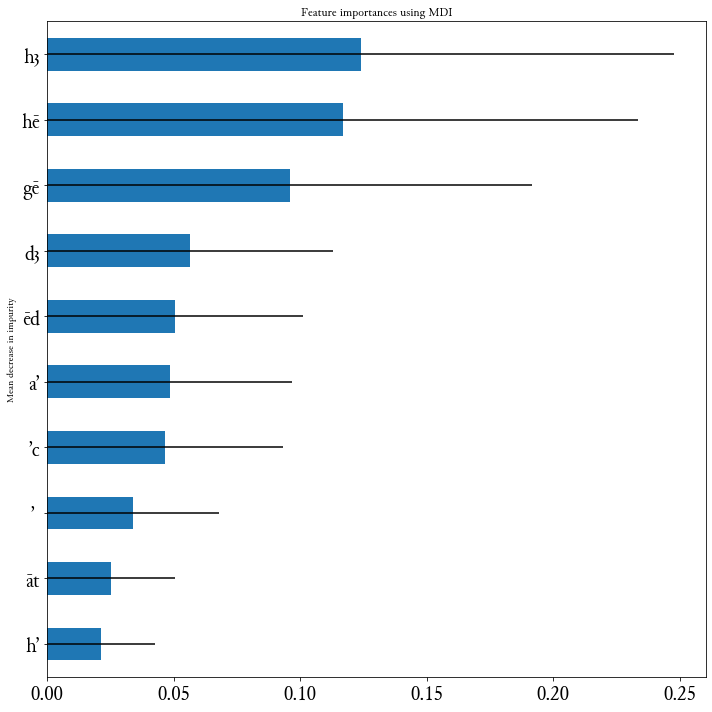

In [175]:
classes = ['W' if sig == 'Wenen, ONB, 12857' else 'rest' for sig in alpha['signature']]

feature_names = vectorizer.get_feature_names()
forest = RandomForestClassifier(random_state=0)
forest.fit(BOW, classes)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

cutoff = 10
forest_importances = pd.Series(importances, index=feature_names)
std = pd.Series(std, index=feature_names)
forest_importances = forest_importances.sort_values(ascending=False).head(cutoff)[::-1]
std = forest_importances.loc[forest_importances.index].head(cutoff)[::-1]

fig, ax = plt.subplots(figsize=(10, 10))
forest_importances.plot.barh(xerr=std, ax=ax, fontsize=20)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [215]:
BOW = pd.DataFrame(BOW, columns=feature_names)
BOW = BOW[forest_importances.index]
BOW.index = classes
BOW

,hʼ,āt,ʼ,ʼc,aʼ,ēd,dꝫ,gē,hē,hꝫ
rest,-0.407020,-0.942534,-2.067168,-0.719043,-1.349819,2.233840,-1.543198,-1.703266,1.672929,0.196185
rest,-0.111995,-1.472092,-2.011077,-0.719043,-1.349819,-0.475486,-1.543198,-1.485339,1.861815,-0.094162
rest,-0.621759,-0.789910,-2.355401,-0.719043,-1.349819,0.485522,-1.543198,-1.431391,2.470970,-0.608487
rest,1.831996,-1.720823,-1.589311,-0.719043,-1.349819,0.873533,-1.543198,-1.124434,1.726784,-0.608487
rest,-0.398628,-1.132484,-2.385086,-0.719043,-1.349819,0.148733,-1.543198,-1.703266,1.112631,-0.608487
...,...,...,...,...,...,...,...,...,...,...
rest,-0.333108,0.241645,1.078050,-0.402556,0.379495,-0.042502,0.741083,0.641414,-0.954914,-0.608487
rest,0.672229,-0.270881,0.874963,-0.397524,1.027041,-0.337643,1.515775,1.155085,-0.591374,-0.608487
rest,0.584636,0.162242,0.399523,-0.050944,0.582829,-0.469427,1.415809,0.936513,-0.846862,0.170272
rest,1.323447,0.498876,1.408729,-0.719043,0.110531,-0.677014,0.742378,0.540742,-0.458536,1.156854


In [241]:
bow = pd.melt(BOW, value_vars=BOW.columns, ignore_index=False, var_name='abbreviation', value_name='score')
bow = bow.reset_index()
bow['origin'] = bow['index']
bow

,index,abbreviation,score,origin
0,rest,hʼ,-0.407020,rest
1,rest,hʼ,-0.111995,rest
2,rest,hʼ,-0.621759,rest
3,rest,hʼ,1.831996,rest
4,rest,hʼ,-0.398628,rest
...,...,...,...,...
6925,rest,hꝫ,-0.608487,rest
6926,rest,hꝫ,-0.608487,rest
6927,rest,hꝫ,0.170272,rest
6928,rest,hꝫ,1.156854,rest


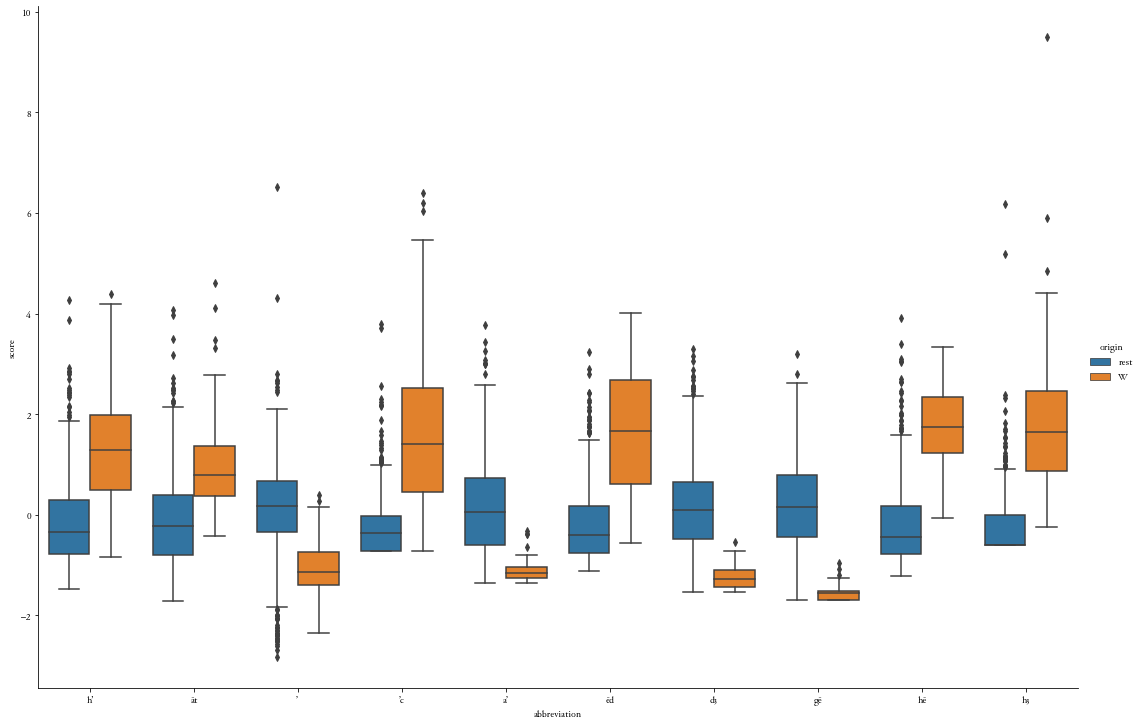

In [242]:
sns.catplot(x="abbreviation", hue="origin", y="score", data=bow, kind='box', height=10, aspect=1.5);

## Text Annotations

Vragen:
- Inhoud teksten via korte karakterisering toevoegen aan spreadsheet hieronder?
- Wie zijn scribe1, scribe2, etc? Ander principe dan ABC?
- Nog None in production unit kolom: filteren?

In [20]:
meta = transcriptions[['codex_sig', 'production unit', 'date', 'id']].drop_duplicates()
meta = meta.sort_values('id')
meta = meta.drop('id', axis=1)
meta.to_excel('production_units.xlsx', header=True, index=False)
meta

,codex_sig,production unit,date
0,"Brussel, KBR, 1805-1808",I,1400
4,"Brussel, KBR, 1805-1808",I,1395
262,"Brussel, KBR, 1805-1808",II,1395
390,"Brussel, KBR, 1805-1808",III,1395
430,"Brussel, KBR, 2485",I,1373
...,...,...,...
13732,"Wenen, ONB, 65",III,1375-1400
13761,"Wenen, ONB, 65",IV,1375-1400
8008,"Philadelphia, Lewis E 199",NaN,NaN
8936,"Wenen, ONB, 12857",NaN,NaN


In [153]:
meta[meta.isna()]

,codex_sig,production unit
0,NaN,NaN
262,NaN,NaN
390,NaN,NaN
406,NaN,NaN
430,NaN,NaN
...,...,...
13257,NaN,NaN
13463,NaN,NaN
13469,NaN,NaN
13732,NaN,NaN


In [154]:
merged = []
for d, s in H.groupby('num_date'):
    print(d)
    merged.append((d, ' '.join(s['text'])))
merged = pd.DataFrame(merged, columns=('date', 'text'))
merged

1337.5
1362.5
1373.0
1378.0
1380.0
1387.5
1392.0
1393.5
1394.0
1395.0
1402.0


,date,text
0,1337.5,es and net aeroeg ē en wna M8 Sadoch ghebaer a...
1,1362.5,Dit boc es des cloesters vā sente pauwels ī zo...
2,1373.0,Jn dē name ons herē ihʼs kersts Hier beghīt de...
3,1378.0,Hier volghen de capiteelle op des heilechs vad...
4,1380.0,NV willic trecken .i. Cussen vte Cussene Daer ...
5,1387.5,ne E laet mi ēmer sere verladē met minnē ongh...
6,1392.0,Dit es de ꝓloghe op der minnē boec Dit boec he...
7,1393.5,Des paeꝰ nycholaꝰ decᵉtē vā dʼ electien wt dec...
8,1394.0,hʼ ian vā rusbroec tgeloeue Dit maecte hʼ ian ...
9,1395.0,De dʼde boec gaꝫ hiʼ vte Hiʼ volgen dē capitee...


In [125]:

vec = TfidfVectorizer(use_idf=True, max_features=500, ngram_range=(2, 2), analyzer='char')
BOW = vec.fit_transform(merged['text']).toarray()
BOW = preprocessing.scale(BOW)
BOW.shape

(7, 500)

In [126]:
taus = []
for idx, f in enumerate(vec.get_feature_names()):
    tau, prob = kendalltau(BOW[:, idx], merged['date'])
    taus.append((idx, f, tau, prob))
taus = pd.DataFrame(taus, columns=['idx', 'feature', 'tau', 'prob'])
taus = taus.sort_values('tau')

In [127]:
display(taus.head())

,idx,feature,tau,prob
460,460,ʼe,-0.904762,0.002778
121,121,e-,-0.809524,0.010714
186,186,i-,-0.809524,0.010714
212,212,j,-0.714286,0.030159
159,159,gg,-0.714286,0.030159


In [128]:
display(taus.tail())

,idx,feature,tau,prob
210,210,iꝰ,0.878310,0.006249
476,476,ᵃc,0.878310,0.006249
396,396,va,0.904762,0.002778
141,141,ev,0.904762,0.002778
346,346,so,0.904762,0.002778


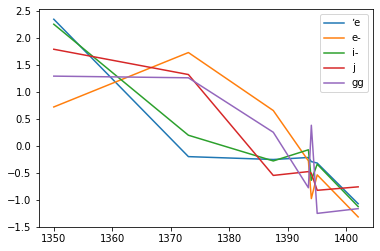

In [129]:
for _, row in taus.head().iterrows():
    plt.plot(merged['date'], BOW[:, row['idx']], label=row['feature'])
plt.legend();

/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 42864 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 42864 missing from current font.
  font.set_text(s, 0, flags=flags)


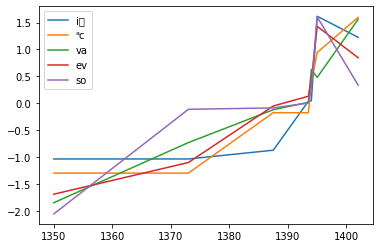

In [130]:
for _, row in taus.tail().iterrows():
    plt.plot(merged['date'], BOW[:, row['idx']], label=row['feature'])
plt.legend();

In [46]:
segment_size = 25000
segments = []
for _, row in H.iterrows():
    si, ei = 0, segment_size
    text = row['text']
    while ei < len(text):
        segments.append((text[si:ei], row['num_date'], row['scribe'], row['signature'], row['id'], row['translator']))
        si += segment_size
        ei += segment_size

segments = pd.DataFrame(segments, columns=['text', 'date', 'scribe', 'signature', 'id', 'translator'])
segments.sample(5)

,text,date,scribe,signature,id,translator
11,ct qᵃmē sine ionghʼen te hē segghēde De stat e...,1387.5,α,"Wenen, ONB, 12857","Wenen, ONB, 12857-IV",NaN
69,hate dꝫ doe ic Eest dat ic doe dꝫ ic nᵗ ē wil...,1387.5,α,"Brussel, KBR, 2849-51","Brussel, KBR, 2849-51-III",NaN
139,al Si dede te samē gᵒt e smal Dat si qualike ...,1402.0,α,"Wenen, ONB, 13708","Wenen, ONB, 13708-VIII",NaN
40,le hulperen hadden . e alsoe met mindrē arbei...,1387.5,α,"Wenen, ONB, 65","Wenen, ONB, 65-II",NaN
66,et . mʼ hi sal oec . mettʼ corīgē ioupīc gebēd...,1387.5,α,"Brussel, KBR, 2849-51","Brussel, KBR, 2849-51-IV",NaN


In [47]:
segments['scribe'].value_counts()

α    136
β      5
Name: scribe, dtype: int64

In [48]:
vec = TfidfVectorizer(use_idf=True, max_features=100, ngram_range=(2, 2), analyzer='char')
BOW = vec.fit_transform(segments['text']).toarray()
BOW = preprocessing.scale(BOW)
BOW.shape

(141, 100)

/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 42859 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 42859 missing from current font.
  font.set_text(s, 0, flags=flags)


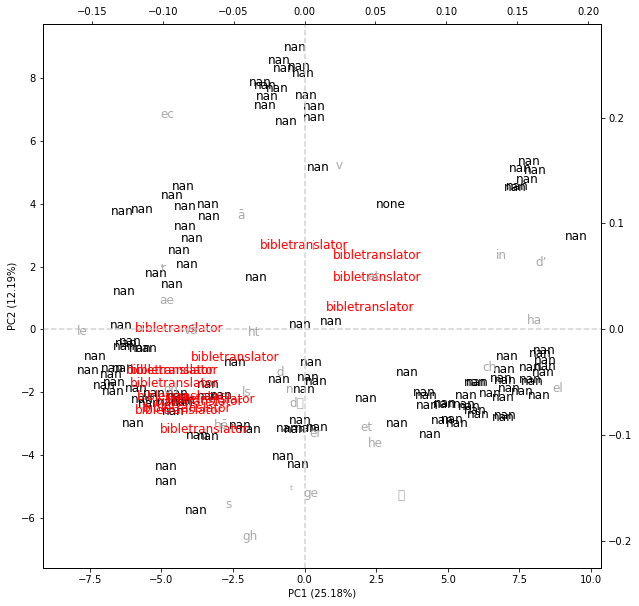

In [52]:
def plot_pca(document_proj, loadings, var_exp, labels, sigs):
    # first the texts:
    fig, text_ax = plt.subplots(figsize=(10, 10))
    x1, x2 = documents_proj[:, 0], documents_proj[:, 1]
    text_ax.scatter(x1, x2, facecolors='none')
    for p1, p2, author, s in zip(x1, x2, labels, sigs):
        color = 'red' if s == 'bibletranslator' else 'black'
        if s == 'Wenen, ONB, 65':
            color = 'green'     
        text_ax.text(p1, p2, s, ha='center',
                     color=color, va='center', fontsize=12)

    # add variance information to the axis labels:
    text_ax.set_xlabel(f'PC1 ({var_exp[0] * 100:.2f}%)')
    text_ax.set_ylabel(f'PC2 ({var_exp[1] * 100:.2f}%)')
    
    # now the loadings:
    loadings_ax = text_ax.twinx().twiny()
    l1, l2 = loadings[:, 0], loadings[:, 1]
    lc = l1 * l2
    m = 30
    top_idxs = lc.argsort()[::-1][:m]
    
    loadings_ax.scatter(l1[top_idxs], l2[top_idxs], facecolors='none');
    for x, y, loading in zip(l1, l2, np.array(vec.get_feature_names())[top_idxs]):
        loadings_ax.text(x, y, loading, ha='center', va='center',
                         color='darkgrey', fontsize=12)

    mpl_axes_aligner.align.yaxes(text_ax, 0, loadings_ax, 0)
    mpl_axes_aligner.align.xaxes(text_ax, 0, loadings_ax, 0)
    
    # add lines through origins:
    plt.axvline(0, ls='dashed', c='lightgrey', zorder=0)
    plt.axhline(0, ls='dashed', c='lightgrey', zorder=0);

# fit the pca:
pca = sklearn.decomposition.PCA(n_components=2)
documents_proj = pca.fit_transform(BOW)
loadings = pca.components_.transpose()
var_exp = pca.explained_variance_ratio_

plot_pca(documents_proj, loadings, var_exp, segments['scribe'], segments['translator'])

## Stylochronometry

/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 42859 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 42859 missing from current font.
  font.set_text(s, 0, flags=flags)


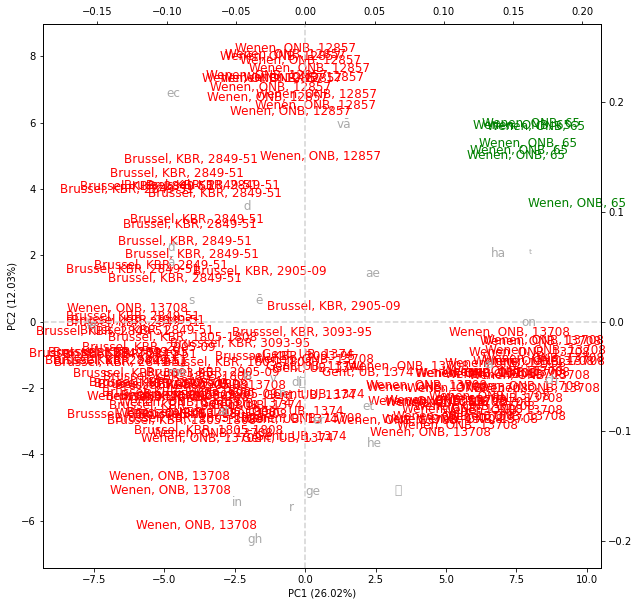

In [56]:
P = segments[segments['scribe'] == 'α']
vec = TfidfVectorizer(use_idf=True, max_features=100, ngram_range=(2, 2), analyzer='char')
BOW = vec.fit_transform(P['text']).toarray()
BOW = preprocessing.scale(BOW)
BOW.shape

def plot_pca(document_proj, loadings, var_exp, labels, sigs):
    # first the texts:
    fig, text_ax = plt.subplots(figsize=(10, 10))
    x1, x2 = documents_proj[:, 0], documents_proj[:, 1]
    text_ax.scatter(x1, x2, facecolors='none')
    for p1, p2, author, s in zip(x1, x2, labels, sigs):
        color = 'red'
        if s == 'Wenen, ONB, 65':
            color = 'green'     
        text_ax.text(p1, p2, s, ha='center',
                     color=color, va='center', fontsize=12)

    # add variance information to the axis labels:
    text_ax.set_xlabel(f'PC1 ({var_exp[0] * 100:.2f}%)')
    text_ax.set_ylabel(f'PC2 ({var_exp[1] * 100:.2f}%)')
    
    # now the loadings:
    loadings_ax = text_ax.twinx().twiny()
    l1, l2 = loadings[:, 0], loadings[:, 1]
    lc = l1 * l2
    m = 30
    top_idxs = lc.argsort()[::-1][:m]
    
    loadings_ax.scatter(l1[top_idxs], l2[top_idxs], facecolors='none');
    for x, y, loading in zip(l1, l2, np.array(vec.get_feature_names())[top_idxs]):
        loadings_ax.text(x, y, loading, ha='center', va='center',
                         color='darkgrey', fontsize=12)

    mpl_axes_aligner.align.yaxes(text_ax, 0, loadings_ax, 0)
    mpl_axes_aligner.align.xaxes(text_ax, 0, loadings_ax, 0)
    
    # add lines through origins:
    plt.axvline(0, ls='dashed', c='lightgrey', zorder=0)
    plt.axhline(0, ls='dashed', c='lightgrey', zorder=0);

# fit the pca:
pca = sklearn.decomposition.PCA(n_components=2)
documents_proj = pca.fit_transform(BOW)
loadings = pca.components_.transpose()
var_exp = pca.explained_variance_ratio_

plot_pca(documents_proj, loadings, var_exp, P['scribe'], P['signature'])

/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 42859 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 42859 missing from current font.
  font.set_text(s, 0, flags=flags)


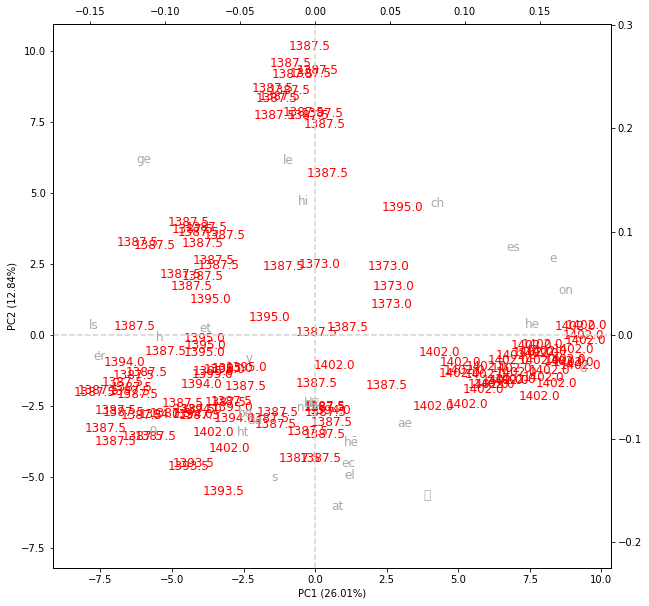

In [57]:
P = segments[segments['scribe'] == 'α']
P = segments[segments['signature'] != 'Wenen, ONB, 65']
vec = TfidfVectorizer(use_idf=True, max_features=100, ngram_range=(2, 2), analyzer='char')
BOW = vec.fit_transform(P['text']).toarray()
BOW = preprocessing.scale(BOW)
BOW.shape

def plot_pca(document_proj, loadings, var_exp, labels, sigs):
    # first the texts:
    fig, text_ax = plt.subplots(figsize=(10, 10))
    x1, x2 = documents_proj[:, 0], documents_proj[:, 1]
    text_ax.scatter(x1, x2, facecolors='none')
    for p1, p2, author, s in zip(x1, x2, labels, sigs):
        color = 'red'
        if s == 'Wenen, ONB, 65':
            color = 'green'     
        text_ax.text(p1, p2, s, ha='center',
                     color=color, va='center', fontsize=12)

    # add variance information to the axis labels:
    text_ax.set_xlabel(f'PC1 ({var_exp[0] * 100:.2f}%)')
    text_ax.set_ylabel(f'PC2 ({var_exp[1] * 100:.2f}%)')
    
    # now the loadings:
    loadings_ax = text_ax.twinx().twiny()
    l1, l2 = loadings[:, 0], loadings[:, 1]
    lc = l1 * l2
    m = 30
    top_idxs = lc.argsort()[::-1][:m]
    
    loadings_ax.scatter(l1[top_idxs], l2[top_idxs], facecolors='none');
    for x, y, loading in zip(l1, l2, np.array(vec.get_feature_names())[top_idxs]):
        loadings_ax.text(x, y, loading, ha='center', va='center',
                         color='darkgrey', fontsize=12)

    mpl_axes_aligner.align.yaxes(text_ax, 0, loadings_ax, 0)
    mpl_axes_aligner.align.xaxes(text_ax, 0, loadings_ax, 0)
    
    # add lines through origins:
    plt.axvline(0, ls='dashed', c='lightgrey', zorder=0)
    plt.axhline(0, ls='dashed', c='lightgrey', zorder=0);

# fit the pca:
pca = sklearn.decomposition.PCA(n_components=2)
documents_proj = pca.fit_transform(BOW)
loadings = pca.components_.transpose()
var_exp = pca.explained_variance_ratio_

plot_pca(documents_proj, loadings, var_exp, P['scribe'], P['date'])

(134, 100)
134


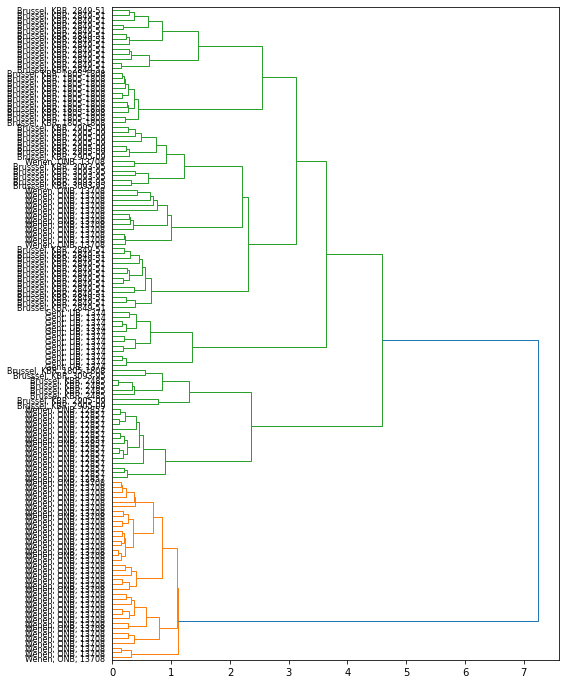

In [58]:
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hierarchy
import scipy.spatial.distance as scidist

print(BOW.shape)
print(len(P['signature']))

# 1. Calculate pairwise distances
dm = scidist.pdist(BOW, 'cosine')

# 2. Establish branch structure
linkage_object = hierarchy.linkage(dm, method='ward')

# 3. Visualize
def plot_tree(linkage_object, labels, figsize=(8, 12), ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    with plt.rc_context({'lines.linewidth': 1.0}):
        hierarchy.dendrogram(
            linkage_object, labels=labels,
            orientation='right',
            ax=ax,
            #link_color_func=lambda c: 'black',
            leaf_font_size=8, leaf_rotation=0)

plot_tree(linkage_object, list(P['signature']))

In [59]:
P = segments[(segments['scribe'] == 'α') & (P['signature'] != 'Wenen, ONB, 65')]
P.index = range(len(P))
P.head()

,text,date,scribe,signature,id,translator
0,SEneca als wijt horē . Was wt spaengē geborē ....,1387.5,α,"Gent, UB, 1374","Gent, UB, 1374-II",NaN
1,pⁱngē In dē oudē eest ōbeqᵃme . So du meʼre be...,1387.5,α,"Gent, UB, 1374","Gent, UB, 1374-II",NaN
2,soude vol gē die meʼre scare . Alsic wille mꝫ...,1387.5,α,"Gent, UB, 1374","Gent, UB, 1374-II",NaN
3,s . Juuenaels ꝓuʼbiē PErciꝰ endt hier sine tal...,1387.5,α,"Gent, UB, 1374","Gent, UB, 1374-II",NaN
4,loemen : ¶ Jckē clage nēmʼmeʼre : Dꝫ die scalc...,1387.5,α,"Gent, UB, 1374","Gent, UB, 1374-II",NaN


In [60]:
vec = TfidfVectorizer(use_idf=True, max_features=1000, ngram_range=(1, 1), analyzer='char')
BOW = vec.fit_transform(P['text']).toarray()
BOW = preprocessing.scale(BOW)
BOW.shape

(129, 106)

In [61]:
n_iter = 1000

taus = []

for iter in tqdm(list(range(n_iter))):
    s = P.groupby('id').sample(1)
    ranks = np.argsort(s['date'])
    p = pd.DataFrame(BOW[s.index, :], columns=vec.get_feature_names())
    p = p.iloc[ranks]
    taus.append([kendalltau(p[f].values, range(0, len(p)))[1] for f in vec.get_feature_names()])
    
taus = pd.DataFrame(taus, columns=vec.get_feature_names())
taus

100%|██████████| 1000/1000 [01:03<00:00, 15.83it/s]


,,+,-,.,0,1,2,3,4,5,...,,,,,,,,,,
0,0.000050,0.278599,0.002082,0.033931,0.952599,0.141976,0.800125,0.694672,0.059478,0.201643,...,0.190754,0.370601,0.096648,0.096648,0.037477,NaN,0.004060,0.582640,0.942418,0.041958
1,0.000966,0.828446,0.004326,0.107397,0.447926,0.389333,0.156239,0.138557,0.041051,0.115331,...,0.446079,0.319818,0.230333,0.096648,0.308943,NaN,0.089643,0.171218,0.067952,0.032497
2,0.000172,0.875673,0.002989,0.029806,0.586002,0.105150,0.263800,0.012920,0.065957,0.055412,...,0.337131,1.000000,0.715062,0.096648,0.278771,NaN,0.010735,0.074851,0.164000,0.067952
3,0.000643,0.828446,0.000967,0.005012,0.977132,0.137852,0.307014,0.352091,0.009809,0.046822,...,0.539205,0.862001,0.321738,0.096648,0.171621,NaN,0.027940,0.733716,0.064738,0.011651
4,0.000172,0.861891,0.000790,0.008158,0.081947,0.028203,0.029132,0.172759,0.003676,0.057371,...,0.539205,0.584270,0.321738,0.096648,0.061375,NaN,0.006956,0.068314,0.942418,0.219471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.000339,0.613123,0.000218,0.043616,0.160142,0.059478,0.028075,0.155626,0.082286,0.062544,...,0.749761,0.690680,0.096648,0.096648,0.037969,NaN,0.009663,0.619051,0.942418,0.219471
996,0.000966,NaN,0.001925,0.026110,0.171560,0.105150,0.165468,0.024620,0.070980,0.059478,...,0.246619,0.709531,0.096648,0.096648,0.071053,NaN,0.014375,0.138557,0.942418,0.219471
997,0.000136,NaN,0.000321,0.029806,0.026128,0.217823,0.060990,0.094718,0.002812,0.512980,...,0.476086,0.471803,0.230333,0.096648,0.015228,NaN,0.084731,0.167884,NaN,0.011651
998,0.000216,0.930684,0.000790,0.029806,0.718079,0.048286,0.110431,0.032128,0.021539,0.012920,...,0.226875,0.920755,0.296575,0.096648,0.037969,NaN,0.024211,0.456290,0.064738,0.067952


/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 7651 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 11819 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 11820 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 11821 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 42841 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/

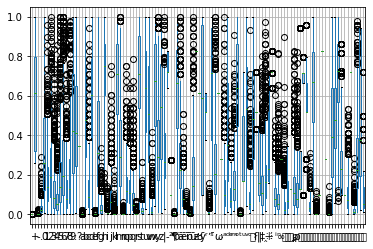

In [62]:
taus.boxplot();

/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 57684 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 58981 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 61785 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 42845 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 42863 missing from current font.
  font.set_text(s, 0.0, flags=flags)


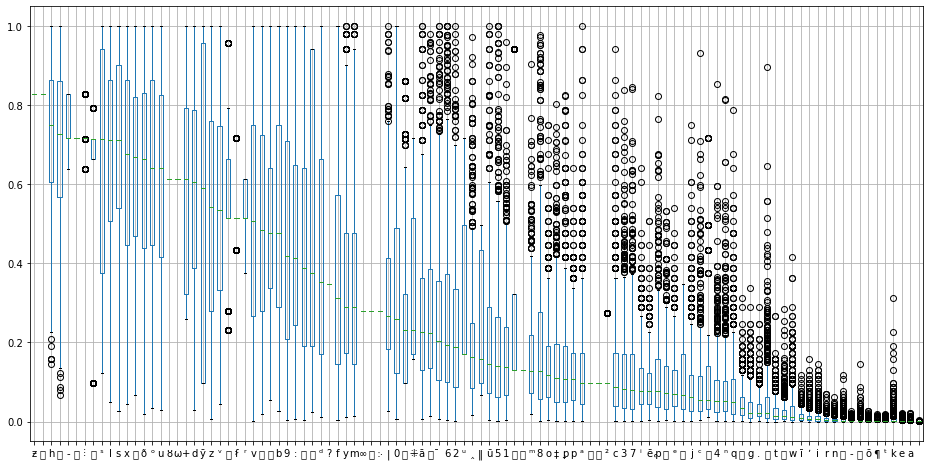

In [63]:
meds = taus.median()
meds.sort_values(ascending=False, inplace=True)
taus = taus[meds.index]
taus.boxplot(figsize=(16, 8));

In [64]:
meds.head().index

Index(['ƶ', '', 'h', '', '­'], dtype='object')

In [65]:
taus

,ƶ,,h,,­,,⁝,ꝝ,ˢ,l,...,ꝰ,-,,ō,¶,ᵗ,k,e,a,
0,NaN,0.828446,0.606166,0.370601,NaN,NaN,0.717982,0.663621,0.644249,0.208260,...,0.008158,0.002082,0.002499,0.000216,0.001909,0.001177,0.004233,0.000136,0.000039,0.000050
1,NaN,NaN,0.825272,0.319818,NaN,NaN,NaN,0.715062,0.942418,0.417155,...,0.000339,0.004326,0.011109,0.000966,0.002255,0.004233,0.000522,0.000790,0.002499,0.000966
2,NaN,0.828446,0.825272,1.000000,NaN,NaN,0.717982,0.096648,0.942418,0.507142,...,0.000339,0.002989,0.000339,0.001728,0.000421,0.000966,0.004233,0.000421,0.000790,0.000172
3,NaN,NaN,0.417155,0.862001,NaN,NaN,0.828446,0.715062,0.497785,0.825272,...,0.001728,0.000967,0.000421,0.005915,0.003338,0.002499,0.049254,0.001728,0.000643,0.000643
4,0.828446,0.828446,0.941346,0.584270,0.638805,NaN,0.717982,0.715062,0.794130,1.000000,...,0.005915,0.000790,0.009534,0.001429,0.000801,0.001177,0.000084,0.000966,0.008158,0.000172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,NaN,0.787272,0.690680,NaN,NaN,0.828446,0.096648,0.794130,0.749761,...,0.006957,0.000218,0.002499,0.002082,0.000342,0.005915,0.000010,0.002082,0.000966,0.000339
996,0.828446,0.828446,0.640952,0.709531,0.828446,NaN,0.717982,0.096648,0.601737,0.825272,...,0.003564,0.001925,0.003564,0.002499,0.000498,0.000790,0.000065,0.001429,0.000017,0.000966
997,0.828446,0.828446,1.000000,0.471803,0.828446,NaN,NaN,0.663621,0.164000,0.787272,...,0.000050,0.000321,0.000084,0.000522,0.008381,0.001177,0.001728,0.001177,0.000522,0.000136
998,0.828446,0.828446,0.980433,0.920755,0.638805,NaN,0.717982,0.715062,0.497785,0.749761,...,0.000790,0.000790,0.000421,0.001728,0.001455,0.005915,0.002989,0.005012,0.000271,0.000216


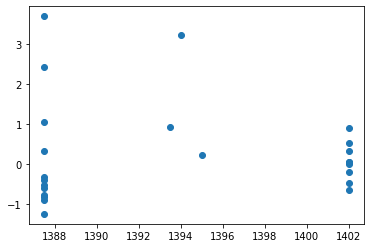

In [66]:
fig, ax = plt.subplots()

s = P.groupby('id').sample(1)
ranks = np.argsort(s['date'])
p = pd.DataFrame(BOW[s.index, :], columns=vec.get_feature_names())
p = p.iloc[ranks]
ax.scatter(s['date'], p['f'].values);

In [72]:
P

,text,date,scribe,signature,id,translator
0,SEneca als wijt horē . Was wt spaengē geborē ....,1387.5,α,"Gent, UB, 1374","Gent, UB, 1374-II",NaN
1,pⁱngē In dē oudē eest ōbeqᵃme . So du meʼre be...,1387.5,α,"Gent, UB, 1374","Gent, UB, 1374-II",NaN
2,soude vol gē die meʼre scare . Alsic wille mꝫ...,1387.5,α,"Gent, UB, 1374","Gent, UB, 1374-II",NaN
3,s . Juuenaels ꝓuʼbiē PErciꝰ endt hier sine tal...,1387.5,α,"Gent, UB, 1374","Gent, UB, 1374-II",NaN
4,loemen : ¶ Jckē clage nēmʼmeʼre : Dꝫ die scalc...,1387.5,α,"Gent, UB, 1374","Gent, UB, 1374-II",NaN
...,...,...,...,...,...,...
124,was ī dlāt daʼ Baliu die en staes was genat Di...,1402.0,α,"Wenen, ONB, 13708","Wenen, ONB, 13708-VIII",NaN
125,re mīne gᵒt Noᵃ Hoe jouimaen keyser wʼt .xliii...,1402.0,α,"Wenen, ONB, 13708","Wenen, ONB, 13708-VIII",NaN
126,breke Serapion daer ic af spᵉke Eēs ī sire io...,1402.0,α,"Wenen, ONB, 13708","Wenen, ONB, 13708-VIII",NaN
127,al Si dede te samē gᵒt e smal Dat si qualike ...,1402.0,α,"Wenen, ONB, 13708","Wenen, ONB, 13708-VIII",NaN


In [71]:
s = P.groupby('id').mean()
s
#ranks = np.argsort(s['date'])
#s.iloc[ranks]

,date
id,
"Brussel, KBR, 1805-1808-I",1395.0
"Brussel, KBR, 2849-51-III",1387.5
"Brussel, KBR, 2849-51-IV",1387.5
"Brussel, KBR, 2849-51-V",1387.5
"Brussel, KBR, 2849-51-VI",1387.5
"Brussel, KBR, 2849-51-VII",1387.5
"Brussel, KBR, 2905-09-II",1387.5
"Brusssel, KBR, 3093-95-I",1387.5
"Brusssel, KBR, 3093-95-II",1387.5


## Permutations

In [22]:
num_units = len(P['id'].unique())
num_units

24

In [23]:
import itertools

#permutations = list(itertools.permutations(range(num_units)))
#len(permutations)

In [ ]:
cnt = 0
for perm in itertools.permutations(range(num_units)):
    print(perm)
    cnt += 1
    if cnt > 10:
        break